# <center>Assignment 5: Outlier Detection by Autoencoder and VAE </center>
<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Task-1:-Data-preprocess" data-toc-modified-id="Task-1:-Data-preprocess-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Task 1: Data preprocess</a></span></li><li><span><a href="#Task-2:-Anomaly-detection-by-deep-autoencoder" data-toc-modified-id="Task-2:-Anomaly-detection-by-deep-autoencoder-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Task 2: Anomaly detection by deep autoencoder</a></span></li><li><span><a href="#Task-3:--Anomaly-detection-by-VAE" data-toc-modified-id="Task-3:--Anomaly-detection-by-VAE-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Task 3:  Anomaly detection by VAE</a></span></li></ul></li></ul></li></ul></div>

In this assignment, you'll apply autencoders to detect outliers with the cardiotocogrpahy dataset (http://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/). You'll use two dataset files:
- `hw5_train.csv`: this file only contain normal cases. This is the file for you to train the models
- `hw5_test.csv`: this file has a mixture of normal and outlier cases, as indicated by the `label` field. This file is for you to test model performance

A snapshot of the data is also shown below.

In [ ]:
import pandas as pd

train_data = pd.read_csv("hw5_train.csv")
test_data = pd.read_csv("hw5_test.csv")
print('train.shape', train_data.shape)
print('test.shape', test_data.shape)
test_data.head()


# Add your code here


train.shape (1473, 21)
test.shape (358, 22)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,label
0,0.639815,1.718612,-0.203640,1.405342,-0.683598,-0.061401,-0.278295,-0.154808,-0.051613,-0.420487,...,1.054744,0.369690,-1.441408,0.963083,1.263314,1.278531,1.266007,-0.423387,1.140018,0.0
1,-0.524173,1.241258,-0.203640,0.926323,0.110133,-0.061401,1.745967,-1.351317,0.295824,-0.420487,...,-1.368567,0.919704,1.310644,-0.488279,0.241349,0.193113,0.369432,1.413631,1.140018,0.0
2,1.274717,-0.168902,-0.203640,0.441790,-0.683598,-0.061401,-0.278295,-0.274459,-0.746486,-0.109286,...,0.769649,0.204686,-0.753395,-0.488279,1.263314,1.278531,1.266007,-0.523588,1.140018,0.0
3,1.697985,-0.498194,-0.115723,-0.469100,-0.683598,-0.061401,-0.278295,1.939084,-1.093922,-0.233766,...,1.767483,0.424691,-0.753395,-0.488279,0.842505,1.214683,1.128072,-0.623789,-0.493294,0.0
4,1.486351,-0.447342,-0.203640,-0.328434,0.531478,-0.061401,-0.278295,-0.992364,-0.051613,0.575357,...,-0.370733,0.039682,0.278625,-0.488279,0.722273,0.831594,0.990138,0.144419,1.140018,0.0


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchinfo import summary
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
%matplotlib inline

from numpy.random import seed
seed(123)

### Task 1: Data preprocess

1. `Sample normalization`: For autoencoders, since the loss is the reconstruction errors, it's always necessary to normalize the data to avoid computation overflow of the errors (i.e. approaching infinite). For example, variables can be normalized to a range between [0,1] through `min_max normalization` or `percentiles` so that sigmoid activation can be used at the end and loss can be controled within a range. <br><br>
2. Split the traininng dataset into train(80%) and validation(20%) subsets so that you can use the validation dataset to control the train progress.
    - You would need to fix the random state when tuning the parameters for models.

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(train_data.iloc[:, 0:21].values)
train_x, val_x = train_test_split(data_scaled, test_size=0.2)

test_x = scaler.transform(test_data.iloc[:, 0:21])
test_y = test_data["label"]
print('label 0 vs label 1 in test: ', test_y.value_counts().tolist())


label 0 vs label 1 in test:  [182, 176]


### Task 2: Anomaly detection by deep autoencoder

1. First, create a `deep autoencoder` as follows:
    - Set the dimension of the bottleneck layer to 2 
    - Train the autoencoder using the train/validation subsets
    - Since this dataset is very small and simple, do not use a complex model here
    - You can try different setting (activation, regularization) on the hidden layers, and figure out which combination is better on the test set<br><br>
2. After training, reconstruct samples in the `train` data file and calculate the `reconstruction errors`. Assuming the `reconstruction errors` follows a normal distribution, fit a normal distribution with the errors to get `mean` and `std` (hint, you can use `scipy.stats.norm.fit()`). <br><br>
3. Next, reconstruct samples in the `test` dataset and calculate the reconstruction errors. Let's call the errors `test_reconstruction errors` <br><br>
4. Since we only build the autoencoder using normal cases, if a test case is an outlier, we would expect it has a large reconstruction error. We can calculate the cdf of the error with regard to the fitted normal distribution. If its `cdf > 95%`, then we predict it as an outlier (hint: you can use `scipy.stats.norm.cdf()` to get the cdf) <br><br>
5. After you produce predictions for test samples, calculate confusion matrix, precision and recall on the test dataset. <br><br>
6. Visualize reconstruction errors and latent variables<br><br> 
7. Analysis:
    - Describe how you choose the hyperparameters, e.g. dimension of each layer, activation function, loss function etc.
    - Discuss whether you are able to detect outliers by reconstruction errors. 

In [ ]:
class AE_FC(nn.Module):

    def __init__(self,input_dim,hidden_dim):
        super(AE_FC, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)

        return decoder_output
    
    def get_latent_var(self, dataset, batch_size = 64):
        
        latent_data = []
        
        data_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=False)
        
        self.eval()  # start to evaluate the model
        
        with torch.no_grad():  # tell pytorch not to update parameters

            for x in data_loader:
          
              x = x.to(device)
            
              outputs = self.encoder(x)
                
              latent_data.append(outputs.cpu().numpy())
        
        latent_data = np.concatenate(latent_data, axis = 0)  

        return latent_data
    
    def decode(self, dataset, batch_size = 64):
        
        decoded_data = []
        
        data_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=False)
        
        self.eval()  # start to evaluate the model
        
        with torch.no_grad():  # tell pytorch not to update parameters

            for x in data_loader:
          
              x = x.to(device)
            
              outputs = self.forward(x)
                
              decoded_data.append(outputs.cpu().numpy())
        
        decoded_data = np.concatenate(decoded_data, axis = 0)  
        
        return decoded_data
            

In [ ]:
class Trans_dataset(Dataset):
    def __init__(self, x):
        self.x = torch.Tensor(x)
    
    def __getitem__(self, index):
        return self.x[index]
    
    def __len__(self):
        return self.x.size()[0]

In [ ]:
train_dataset = Trans_dataset(train_x)
eval_dataset = Trans_dataset(val_x)
test_dataset = Trans_dataset(test_x)

In [ ]:
def train(train_dataset, val_dataset,  device, model, batch_size=64, num_epochs=20, learning_rate = 1e-3):

  train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
  valid_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch_size,
                          shuffle=False)
  

  # move the model to device
  model = model.to(device)  # move the model to gpu or cpu

  # history
  history = {'train_loss': [],
             'valid_loss': [],
             }

  # set up loss function and optimizer
  criterion = nn.BCELoss() 
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # pass in the parameters to be updated and learning rate

  # traning loop
  print('Training Starts:')
  num_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      model.train()  # start to train the model, activate training behavior
      train_loss = 0
      train_acc = 0
      for i, x in enumerate(train_loader):
          # reshape mini-batch data to [N, 784] matrix    28*28 =784
          # load it to the active device
          x = x.to(device)  
          
          # forward
          outputs = model(x)  # forward
          cur_train_loss = criterion(outputs, x)  # loss
          # backward
          cur_train_loss.backward()  # run back propagation
          optimizer.step()  # optimizer update all model parameters
          optimizer.zero_grad()  # set gradient to zero, avoid gradient accumulating
          # loss
          train_loss += cur_train_loss
          
      # valid
      model.eval()  # start to evaluate the model
      with torch.no_grad():  # tell pytorch not to update parameters
          val_loss = 0
        
          for x in valid_loader:
              # calculate validation loss
              x = x.to(device)
              outputs = model(x)
              cur_valid_loss = criterion(outputs, x)
              val_loss += cur_valid_loss
      
      # print & record
      train_loss = train_loss / len(train_loader)
      val_loss = val_loss / len(valid_loader)
      print(f"Epoch:{epoch + 1} / {num_epochs}, train loss:{train_loss:.5f}, valid loss:{val_loss:.5f}")
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(val_loss)

  return history, model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
input_dim = 21
hidden_dim = 2

AE_model = AE_FC(input_dim=input_dim, hidden_dim = hidden_dim)
summary(AE_model, input_size = (batch_size,21))

history, model = train(train_dataset = train_dataset, 
                                    val_dataset=eval_dataset,
                       device=device, model=AE_model, batch_size=128, num_epochs=300)

Training Starts:
Epoch:1 / 300, train loss:0.67342, valid loss:0.66996
Epoch:2 / 300, train loss:0.66631, valid loss:0.66297
Epoch:3 / 300, train loss:0.65955, valid loss:0.65662
Epoch:4 / 300, train loss:0.65323, valid loss:0.65062
Epoch:5 / 300, train loss:0.64765, valid loss:0.64478
Epoch:6 / 300, train loss:0.64176, valid loss:0.63902
Epoch:7 / 300, train loss:0.63593, valid loss:0.63326
Epoch:8 / 300, train loss:0.63025, valid loss:0.62750
Epoch:9 / 300, train loss:0.62445, valid loss:0.62172
Epoch:10 / 300, train loss:0.61835, valid loss:0.61592
Epoch:11 / 300, train loss:0.61284, valid loss:0.61013
Epoch:12 / 300, train loss:0.60697, valid loss:0.60435
Epoch:13 / 300, train loss:0.60138, valid loss:0.59862
Epoch:14 / 300, train loss:0.59566, valid loss:0.59292
Epoch:15 / 300, train loss:0.58972, valid loss:0.58729
Epoch:16 / 300, train loss:0.58463, valid loss:0.58175
Epoch:17 / 300, train loss:0.57904, valid loss:0.57631
Epoch:18 / 300, train loss:0.57321, valid loss:0.57099
Ep

In [ ]:
decode_train = model.decode(train_dataset)
reconstruct_error = np.sum(np.abs(train_x - decode_train), axis=-1)

mu, std = norm.fit(reconstruct_error)

decoded_test = model.decode(test_dataset)
test_reconstruct_error = np.sum(np.abs(test_x - decoded_test), axis=-1)
cdf = norm.cdf(test_reconstruct_error, loc=mu, scale=std)
print("Reconstruction error cut off is {0:.2f}\n".format(norm.ppf(0.95, loc=mu, scale=std)))

print(classification_report(test_y, np.where(cdf>0.95, 1, 0)))
#print(confusion_matrix(test_y, np.where(cdf>0.95, 1, 0)))


# Add your code here

# Below shows test performance. Just a sample. You may get different performance

Reconstruction error cut off is 4.14

              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       182
         1.0       0.91      0.84      0.87       176

    accuracy                           0.88       358
   macro avg       0.88      0.88      0.88       358
weighted avg       0.88      0.88      0.88       358



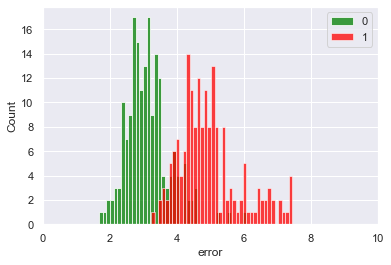

In [ ]:
sns.set() 
test_error_by_class = pd.DataFrame(list(zip(test_reconstruct_error, test_y)), columns=["error", "label"])
sns.histplot(test_error_by_class[test_error_by_class["label"]==0]["error"], bins=40, color="green",  label="0")
sns.histplot(test_error_by_class[test_error_by_class["label"]==1]["error"], bins=40, color="red", label="1")
plt.xlim(0, 10)
plt.legend()
plt.show()

In [ ]:
train_data

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21
0,0.322363,0.123474,-0.203640,-0.673727,0.657666,-0.061401,-0.278295,-1.171841,0.064200,-0.420487,...,-0.155561,-0.014364,-0.345328,-0.409388,-0.488279,0.000886,0.065417,-0.044371,-0.356586,-0.493294
1,-0.629990,2.193719,-0.162650,0.857411,-0.472948,-0.061401,-0.278295,0.503272,1.338133,-0.420487,...,0.321013,-0.228185,0.314688,0.278625,-0.488279,-0.059229,0.065417,0.231498,-0.289786,-0.493294
2,-0.100905,1.080928,-0.203640,0.093800,-0.362102,-0.061401,-0.278295,0.563098,0.180012,-0.420487,...,-0.473278,0.734012,0.149684,-0.753395,-0.488279,0.121118,0.384658,0.300465,-0.423387,-0.493294
3,-1.899794,-0.919988,-0.203640,1.267627,-0.683598,-0.061401,-0.278295,1.161352,-1.093922,-0.420487,...,-1.267568,0.342006,-2.105373,-1.097401,-0.488279,-1.261541,-1.211544,-1.423716,-0.657189,-0.493294
4,-0.947441,-0.919988,-0.203640,-1.635871,-0.683598,-0.061401,-0.278295,0.263970,-0.746486,0.015195,...,0.003297,-0.976561,-1.500358,-0.753395,-0.488279,-0.419923,-0.381519,-0.527142,-0.623789,1.140018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,-0.735807,0.606979,0.916688,0.476083,0.886610,-0.061401,-0.278295,-1.470968,1.222321,-0.420487,...,1.591878,-0.976561,1.799726,1.310644,0.963083,-0.660385,-0.509216,-0.665076,-0.156184,-0.493294
1469,0.322363,-0.650121,-0.203640,-0.516107,-0.683598,-0.061401,-0.278295,1.221178,-0.978110,-0.420487,...,-0.949852,1.019107,-0.400330,-0.065382,-0.488279,0.662158,0.512354,0.438400,-0.490188,-0.493294
1470,1.486351,0.693191,-0.203640,1.153120,-0.683598,-0.061401,-0.278295,-1.052190,-0.167425,-0.420487,...,-0.314419,1.268566,1.304714,-0.065382,-0.488279,1.263314,1.470075,1.403941,-0.523588,-0.493294
1471,-0.947441,-0.919988,-0.203640,-1.635871,-0.683598,-0.061401,-0.278295,0.263970,-0.746486,0.015195,...,0.003297,-0.976561,-1.500358,-0.753395,-0.488279,-0.419923,-0.381519,-0.527142,-0.623789,1.140018


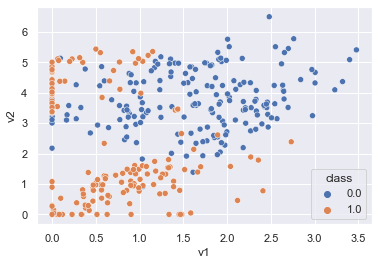

In [ ]:
# scatter plot

encoded_x = model.get_latent_var(test_dataset)
encoded_x = pd.DataFrame(encoded_x, columns=['v1','v2'])
encoded_x["class"] = test_y
sns.scatterplot(x="v1", y="v2", hue="class", data=encoded_x)
plt.show()

### Task 3:  Anomaly detection by VAE

1. Create a VAE model and complete Requirements (1)-(5) as stated in Task 2. 
    - Note, since sampling is used to reconstruct samples, when you reconstruct samples, to reduce the variation in the reconstructed samples, for each sample, you can predict many times, i.e. 100 times, and use the mean of predictions as the final output<br><br>
2. Compare the results you obtained in both models and comment on pros and cons of each model in following three aspects.
    - Performance:
    - Stability:
    - Robustness:    


Possible solution:
- Result is similar
- Due to KL divergence, the latent space is more evenly distributed

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self,input_dim, hidden_dim =10, latent_dim=2):
        super(VariationalEncoder, self).__init__()
        self.flatten = nn.Flatten()
        
        # shared linear layer
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        
        self.relu = nn.ReLU()
        
        # dense layer to produce mean mean
        self.linear2 = nn.Linear(hidden_dim, latent_dim)
        
        # deanse layer to produce variance (log)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)
        
        # reparametrizing
        self.N = torch.distributions.Normal(0, 1)
        

    def forward(self, x):

        x = self.relu(self.linear1(x))
        mu =  self.linear2(x)
        logvar = self.linear3(x)   # output log(var)
        
        sigma = torch.exp(0.5*logvar) # standard deviation
        
        z = mu + sigma*self.N.sample(mu.shape)
        
        # kl divergence of the batch
        kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu**2 - logvar.exp(), axis = -1))
        
        #print(kl.shape, z.shape, mu.shape)
        
        return z, kl

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim, hidden_dim =10, latent_dim=2):
        super(VAE, self).__init__()

        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        encoder_output, kl = self.encoder(x)
        decoder_output = self.decoder(encoder_output)

        return decoder_output, kl
    
    
    def get_latent_var(self, dataset, batch_size = 64):
        
        latent_data = []
        
        data_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=False)
        
        self.eval()  # start to evaluate the model
        
        with torch.no_grad():  # tell pytorch not to update parameters

            for x in data_loader:
          
              x = x.to(device)
            
              outputs, kl = self.encoder(x)
                
              latent_data.append(outputs.cpu().numpy())
        
        latent_data = np.concatenate(latent_data, axis = 0)  

        return latent_data
    
    def decode(self, dataset, batch_size = 64):
        
        decoded_data = []
        
        data_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=False)
        
        self.eval()  # start to evaluate the model
        
        with torch.no_grad():  # tell pytorch not to update parameters

            for x in data_loader:
          
              x = x.to(device)
            
              outputs, kl = self.forward(x)
                
              decoded_data.append(outputs.cpu().numpy())
        
        decoded_data = np.concatenate(decoded_data, axis = 0)  
        
        return decoded_data

In [ ]:
def train_vae(train_dataset, val_dataset,  device, model, batch_size=64, num_epochs=20, learning_rate = 1e-3):

  train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
  valid_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch_size,
                          shuffle=False)
  

  # move the model to device
  model = model.to(device)  # move the model to gpu or cpu

  # history
  history = {'train_loss': [],
             'valid_loss': [],
             }

  # set up loss function and optimizer
  criterion = nn.BCELoss() 
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # pass in the parameters to be updated and learning rate

  # traning loop
  print('Training Starts:')
  num_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      model.train()  # start to train the model, activate training behavior
      train_loss = 0
      train_acc = 0
      for i, x in enumerate(train_loader):
          # reshape mini-batch data to [N, 784] matrix    28*28 =784
          # load it to the active device
          x = x.to(device)  
          
          # forward
          outputs, kl = model(x)  # forward
          cur_train_loss = criterion(outputs, x)  # loss
          cur_train_loss = cur_train_loss + kl
          #print(cur_train_loss, kl)
          # backward
          cur_train_loss.backward()  # run back propagation
          optimizer.step()  # optimizer update all model parameters
          optimizer.zero_grad()  # set gradient to zero, avoid gradient accumulating
          # loss
          train_loss += cur_train_loss 
          
      # valid
      model.eval()  # start to evaluate the model
      with torch.no_grad():  # tell pytorch not to update parameters
          val_loss = 0
        
          for x in valid_loader:
              # calculate validation loss
              x = x.to(device)
              outputs, kl = model(x)
              cur_valid_loss = criterion(outputs, x)
              val_loss += cur_valid_loss + kl
      
      # print & record
      train_loss = train_loss / len(train_loader)
      val_loss = val_loss / len(valid_loader)
      print(f"Epoch:{epoch + 1} / {num_epochs}, train loss:{train_loss:.5f}, valid loss:{val_loss:.5f}")
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(val_loss)

  return history, model

In [ ]:
original_dim = 21
intermediate_dim = 10
latent_dim = 2
batch_size = 256
epochs = 200
epsilon_std = 1.0

VAE_model = VAE(input_dim = 21, hidden_dim =10, latent_dim=2)
summary(VAE_model, (10, 21))

history, model = train_vae(train_dataset = train_dataset, 
                           val_dataset=eval_dataset,
                           device=device, model=VAE_model, 
                           learning_rate = 1e-3,
                           batch_size=128, num_epochs=100)

Training Starts:
Epoch:1 / 100, train loss:0.84103, valid loss:0.81720
Epoch:2 / 100, train loss:0.79807, valid loss:0.77947
Epoch:3 / 100, train loss:0.76411, valid loss:0.74833
Epoch:4 / 100, train loss:0.73585, valid loss:0.72072
Epoch:5 / 100, train loss:0.71050, valid loss:0.69902
Epoch:6 / 100, train loss:0.68795, valid loss:0.67739
Epoch:7 / 100, train loss:0.66989, valid loss:0.66202
Epoch:8 / 100, train loss:0.65520, valid loss:0.64807
Epoch:9 / 100, train loss:0.64308, valid loss:0.63837
Epoch:10 / 100, train loss:0.63125, valid loss:0.62528
Epoch:11 / 100, train loss:0.62007, valid loss:0.61583
Epoch:12 / 100, train loss:0.60890, valid loss:0.60905
Epoch:13 / 100, train loss:0.60163, valid loss:0.59684
Epoch:14 / 100, train loss:0.59493, valid loss:0.59221
Epoch:15 / 100, train loss:0.58405, valid loss:0.58558
Epoch:16 / 100, train loss:0.57559, valid loss:0.57320
Epoch:17 / 100, train loss:0.56927, valid loss:0.57012
Epoch:18 / 100, train loss:0.56401, valid loss:0.56170
Ep

In [ ]:
decode_train = model.decode(train_dataset)
reconstruct_error = np.sum(np.abs(train_x - decode_train), axis=-1)

mu, std = norm.fit(reconstruct_error)

decoded_test = model.decode(test_dataset)
test_reconstruct_error = np.sum(np.abs(test_x - decoded_test), axis=-1)
cdf = norm.cdf(test_reconstruct_error, loc=mu, scale=std)
print("Reconstruction error cut off is {0:.2f}\n".format(norm.ppf(0.95, loc=mu, scale=std)))

print(classification_report(test_y, np.where(cdf>0.95, 1, 0)))

Reconstruction error cut off is 3.69

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88       182
         1.0       0.90      0.84      0.87       176

    accuracy                           0.88       358
   macro avg       0.88      0.88      0.88       358
weighted avg       0.88      0.88      0.88       358



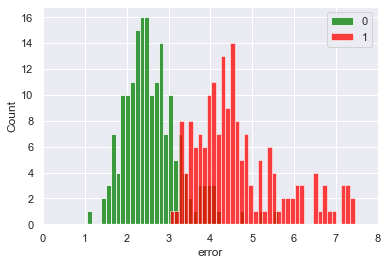

In [ ]:
sns.set() 
test_error_by_class = pd.DataFrame(list(zip(test_reconstruct_error, test_y)), columns=["error", "label"])
sns.histplot(test_error_by_class[test_error_by_class["label"]==0]["error"], bins=40, color="green",  label="0")
sns.histplot(test_error_by_class[test_error_by_class["label"]==1]["error"], bins=40, color="red", label="1")
plt.xlim(0, 8)
plt.legend()
plt.show()

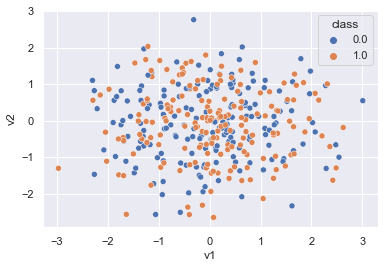

In [ ]:
encoded_x = model.get_latent_var(test_dataset)
encoded_x = pd.DataFrame(encoded_x, columns=['v1','v2'])
encoded_x["class"] = test_y
sns.scatterplot(x="v1", y="v2", hue="class", data=encoded_x)
plt.show()